In [69]:
import pandas as pd
import numpy as np
import xarray as xr
import os

#  Load  and prepare HW and NO_HW df

##  Load HW and NO_HW data

In [70]:
# Load the parquet data from /Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/parquet
#data_dir = '/Users/yguo/DataSpellProjects/hw/data/parquet'
data_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/parquet'
summary_dir = '/Trex/case_results/i.e215.I2000Clm50SpGs.hw_production.02/research_results/summary'

# Range of years for your data
start_year = 1985
end_year = 2013

# Initialize empty DataFrames to store the combined data
df_hw = pd.DataFrame()
df_no_hw= pd.DataFrame()

# Initialize empty lists to store DataFrames
df_hw_list = []
df_no_hw_list = []

# Iterate through each year and combine the Parquet files
for year in range(start_year, end_year + 1):
    # Construct file names for HW and NO_HW data
    file_name_hw = os.path.join(data_dir, f"ALL_HW_{year}_{year}.parquet")
    file_name_no_hw = os.path.join(data_dir, f"ALL_NO_HW_{year}_{year}.parquet")

    # Read Parquet files for the current year
    df_hw_tmp = pd.read_parquet(file_name_hw)
    df_no_hw_tmp = pd.read_parquet(file_name_no_hw)
    # 
    # df_hw_tmp = pd.read_parquet(file_name_hw, engine='pyarrow', dtype_backend='pyarrow')
    # df_no_hw_tmp = pd.read_parquet(file_name_no_hw, engine='pyarrow', dtype_backend='pyarrow')
    
    # Append DataFrames to lists
    df_hw_list.append(df_hw_tmp)
    df_no_hw_list.append(df_no_hw_tmp)

# Concatenate DataFrames from lists once outside the loop
df_hw = pd.concat(df_hw_list)
df_no_hw = pd.concat(df_no_hw_list)

# Now you have df_hw_all and df_no_hw_all containing the combined data from all years
print(df_hw.info())
print(df_no_hw.info())

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7127880 entries, (-40.994766, 288.75, Timestamp('1985-12-01 00:00:00')) to (61.72775, 130.0, Timestamp('1987-08-03 23:00:00'))
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   UHI           float32
 1   UBWI          float32
 2   WIND          float32
 3   RAIN          float32
 4   SNOW          float32
 5   HW            float64
 6   Q2M_R         float32
 7   Q2M_U         float32
 8   VAPOR_PRES_R  float32
 9   VAPOR_PRES_U  float32
dtypes: float32(9), float64(1)
memory usage: 333.7 MB
None
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20839512 entries, (-55.13089, 291.25, Timestamp('1985-01-01 00:00:00')) to (70.20943, 31.25, Timestamp('1987-08-31 23:00:00'))
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   UHI           float32
 1   UBWI          float32
 2   WIND          float32
 3   RAIN          float32
 4   SNOW          float32
 5   HW 

In [71]:
df_hw.head()


UHI      UBWI      WIND  RAIN  \
lat        lon    time                                                      
-40.994766 288.75 1985-12-01 00:00:00  1.284210 -0.116805  4.805232   0.0   
                  1985-12-01 01:00:00  1.196442  0.104045  4.406686   0.0   
                  1985-12-01 02:00:00  1.178253  0.174866  4.008142   0.0   
                  1985-12-01 03:00:00  1.142365  0.199996  3.748525   0.0   
                  1985-12-01 04:00:00  1.093079  0.209863  3.535218   0.0   

                                       SNOW   HW     Q2M_R     Q2M_U  \
lat        lon    time                                                 
-40.994766 288.75 1985-12-01 00:00:00   0.0  1.0  0.006053  0.005438   
                  1985-12-01 01:00:00   0.0  1.0  0.005589  0.005224   
                  1985-12-01 02:00:00   0.0  1.0  0.005315  0.005017   
                  1985-12-01 03:00:00   0.0  1.0  0.005213  0.004948   
                  1985-12-01 04:00:00   0.0  1.0  0.005167  0.004926   

                                       VAPOR_PRES_R  VAPOR_PRES_U  
lat        lon    time                                             
-40.994766 288.75 1985-12-01 00:00:00    849.422302    762.493713  
                  1985-12-01 01:00:00    785.704346    733.800659  
                  1985-12-01 02:00:00    748.270996    705.977356  
                  1985-12-01 03:00:00    734.549744    696.807861  
                  1985-12-01 04:00:00    728.513733    694.144470

##  Add hour, month and year to the df_hw


In [72]:
# Ensure 'time' is of datetime type
df_hw.index = df_hw.index.set_levels([df_hw.index.levels[0], df_hw.index.levels[1], pd.to_datetime(df_hw.index.levels[2])])

# Extract hour, month and year from 'time'
df_hw['hour'] = df_hw.index.get_level_values('time').hour
df_hw['month'] = df_hw.index.get_level_values('time').month
df_hw['year'] = df_hw.index.get_level_values('time').year
df_hw

UHI      UBWI      WIND      RAIN  \
lat        lon    time                                                          
-40.994766 288.75 1985-12-01 00:00:00  1.284210 -0.116805  4.805232  0.000000   
                  1985-12-01 01:00:00  1.196442  0.104045  4.406686  0.000000   
                  1985-12-01 02:00:00  1.178253  0.174866  4.008142  0.000000   
                  1985-12-01 03:00:00  1.142365  0.199996  3.748525  0.000000   
                  1985-12-01 04:00:00  1.093079  0.209863  3.535218  0.000000   
...                                         ...       ...       ...       ...   
 61.727749 130.00 1987-08-03 19:00:00  1.758209  1.018993  1.691223  0.000019   
                  1987-08-03 20:00:00  1.488586  0.851266  1.511483  0.000004   
                  1987-08-03 21:00:00  1.678162  0.829662  1.578975  0.000004   
                  1987-08-03 22:00:00  0.937225  0.462517  1.728877  0.000002   
                  1987-08-03 23:00:00 -0.020630  0.012183  1.878780  0.000000   

                                       SNOW   HW     Q2M_R     Q2M_U  \
lat        lon    time                                                 
-40.994766 288.75 1985-12-01 00:00:00   0.0  1.0  0.006053  0.005438   
                  1985-12-01 01:00:00   0.0  1.0  0.005589  0.005224   
                  1985-12-01 02:00:00   0.0  1.0  0.005315  0.005017   
                  1985-12-01 03:00:00   0.0  1.0  0.005213  0.004948   
                  1985-12-01 04:00:00   0.0  1.0  0.005167  0.004926   
...                                     ...  ...       ...       ...   
 61.727749 130.00 1987-08-03 19:00:00   0.0  1.0  0.007921  0.008189   
                  1987-08-03 20:00:00   0.0  1.0  0.008159  0.008386   
                  1987-08-03 21:00:00   0.0  1.0  0.008143  0.008280   
                  1987-08-03 22:00:00   0.0  1.0  0.008027  0.008107   
                  1987-08-03 23:00:00   0.0  1.0  0.007892  0.007913   

                                       VAPOR_PRES_R  VAPOR_PRES_U  hour  \
lat        lon    time                                                    
-40.994766 288.75 1985-12-01 00:00:00    849.422302    762.493713     0   
                  1985-12-01 01:00:00    785.704346    733.800659     1   
                  1985-12-01 02:00:00    748.270996    705.977356     2   
                  1985-12-01 03:00:00    734.549744    696.807861     3   
                  1985-12-01 04:00:00    728.513733    694.144470     4   
...                                             ...           ...   ...   
 61.727749 130.00 1987-08-03 19:00:00   1258.649292   1300.405029    19   
                  1987-08-03 20:00:00   1296.133301   1331.310669    20   
                  1987-08-03 21:00:00   1293.230957   1314.154419    21   
                  1987-08-03 22:00:00   1273.988892   1286.163696    22   
                  1987-08-03 23:00:00   1251.213501   1254.517822    23   

                                       month  year  
lat        lon    time                              
-40.994766 288.75 1985-12-01 00:00:00     12  1985  
                  1985-12-01 01:00:00     12  1985  
                  1985-12-01 02:00:00     12  1985  
                  1985-12-01 03:00:00     12  1985  
                  1985-12-01 04:00:00     12  1985  
...                                      ...   ...  
 61.727749 130.00 1987-08-03 19:00:00      8  1987  
                  1987-08-03 20:00:00      8  1987  
                  1987-08-03 21:00:00      8  1987  
                  1987-08-03 22:00:00      8  1987  
                  1987-08-03 23:00:00      8  1987  

[7127880 rows x 13 columns]

In [73]:
# # Group by 'lat', 'lon', 'year', 'month', and 'hour', then calculate the mean of 'UHI' and 'UBWI'
# df_hw_avg = df_hw.groupby(['lat', 'lon', 'year', 'month', 'hour']).mean()
# df_hw_avg

In [74]:

# file_name_no_hw = 'NO_HW_1985_1994.parquet'
# #join data_dir and file_name
# no_hw_path = os.path.join(data_dir, file_name_no_hw)
# df_no_hw = pd.read_parquet(no_hw_path)
# print(df_no_hw.info())
# df_no_hw

In [75]:
#todo: add UHI and NO_HW UHI to make sure they are the same as the oringal netcdf data


##  Validate there is not overlap between the HW and NO_HW data

In [76]:
#the key for both df_hw and df_no_hw are lat, lon and time. please show python code that they don't overlap on those keys
# Convert the MultiIndex of both DataFrames to sets
# keys_hw = set(df_hw.index)
# keys_no_hw = set(df_no_hw.index)
# 
# # Check if the intersection of these sets is empty
# overlap = keys_hw & keys_no_hw
# 
# # If the intersection is empty, print that there is no overlap. Otherwise, print the overlapping keys.
# if not overlap:
#     print("There is no overlap between the keys of df_hw and df_no_hw.")
# else:
#     print("The following keys overlap between df_hw and df_no_hw:")
#     print(overlap)

In [77]:

# group df_no_hw by lat, lon, year and hour of the day avaerage UHI and UBWI
df_no_hw.index = df_no_hw.index.set_levels(
    [df_no_hw.index.levels[0], df_no_hw.index.levels[1], pd.to_datetime(df_no_hw.index.levels[2])])
df_no_hw['hour'] = df_no_hw.index.get_level_values('time').hour
df_no_hw['year'] = df_no_hw.index.get_level_values('time').year
df_no_hw_avg = df_no_hw.groupby(['lat', 'lon', 'year', 'hour']).mean()
df_no_hw_avg

UHI      UBWI      WIND      RAIN  \
lat        lon    year hour                                           
-55.130890 291.25 1985 0     0.305542  0.122376  5.615376  0.000024   
                       1     0.366234  0.171864  5.482819  0.000022   
                       2     0.374915  0.186239  5.354490  0.000021   
                       3     0.351239  0.173043  5.357250  0.000021   
                       4     0.331068  0.164803  5.403706  0.000018   
...                               ...       ...       ...       ...   
 70.209427 31.25  1987 19    0.637483  0.289924  4.540127  0.000030   
                       20    0.767799  0.356964  4.426602  0.000040   
                       21    0.861979  0.407398  4.396772  0.000040   
                       22    0.925808  0.462202  4.394841  0.000035   
                       23    0.947882  0.509122  4.392910  0.000029   

                                     SNOW   HW     Q2M_R     Q2M_U  \
lat        lon    year hour                                          
-55.130890 291.25 1985 0     5.028967e-08  0.0  0.005970  0.005953   
                       1     1.021326e-07  0.0  0.005788  0.005787   
                       2     2.436367e-07  0.0  0.005613  0.005618   
                       3     2.910414e-07  0.0  0.005515  0.005517   
                       4     3.003302e-07  0.0  0.005441  0.005444   
...                                   ...  ...       ...       ...   
 70.209427 31.25  1987 19    1.964506e-06  0.0  0.006039  0.006022   
                       20    1.531946e-06  0.0  0.005990  0.005978   
                       21    1.282503e-06  0.0  0.005897  0.005892   
                       22    1.760710e-06  0.0  0.005766  0.005782   
                       23    2.732604e-06  0.0  0.005629  0.005673   

                             VAPOR_PRES_R  VAPOR_PRES_U  
lat        lon    year hour                              
-55.130890 291.25 1985 0       914.766846    912.078369  
                       1       887.165894    886.919250  
                       2       860.696106    861.283936  
                       3       845.745422    845.946411  
                       4       834.454407    834.755371  
...                                   ...           ...  
 70.209427 31.25  1987 19      970.180054    967.304932  
                       20      962.543762    960.365479  
                       21      947.625000    946.543213  
                       22      926.795410    928.944214  
                       23      904.782410    911.528931  

[301272 rows x 10 columns]

#  2: Calculate the difference between UHI in df_hw and df_no_hw

##  UHI HW - NO_HW ( HW hour data - NO_HW yearl average data for the hour) 
the df_no_hw_avg is the average value for a given hour of the day throughout the year.
In the 2018 Zhao paper they seem to just do average the whole 30 years. 
I want to substract the average UHI on the given hour for a given year from the hourly UHI data I have in df_hw, matching the year and hour between the two dataframes.


##  Step 2.1: Reset the index of df_hw and df_no_hw_avg (be careful on the increased memory usage)

In [78]:
df_hw.info()
df_hw_reset = df_hw.reset_index()
df_hw_reset.info()
df_no_hw_avg.info()
df_no_hw_avg_reset = df_no_hw_avg.reset_index()
df_no_hw_avg_reset.info()


<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7127880 entries, (-40.994766, 288.75, Timestamp('1985-12-01 00:00:00')) to (61.72775, 130.0, Timestamp('1987-08-03 23:00:00'))
Data columns (total 13 columns):
 #   Column        Dtype  
---  ------        -----  
 0   UHI           float32
 1   UBWI          float32
 2   WIND          float32
 3   RAIN          float32
 4   SNOW          float32
 5   HW            float64
 6   Q2M_R         float32
 7   Q2M_U         float32
 8   VAPOR_PRES_R  float32
 9   VAPOR_PRES_U  float32
 10  hour          int32  
 11  month         int32  
 12  year          int32  
dtypes: float32(9), float64(1), int32(3)
memory usage: 415.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7127880 entries, 0 to 7127879
Data columns (total 16 columns):
 #   Column        Dtype         
---  ------        -----         
 0   lat           float32       
 1   lon           float32       
 2   time          datetime64[ns]
 3   UHI           float32       
 4  


##   Step 2.2: Merge df_hw with df_no_hw_avg_reset

In [79]:

merged_df = pd.merge(df_hw_reset, df_no_hw_avg_reset[['lat', 'lon', 'year', 'hour', 'UHI', 'UBWI']],
                     on=['lat', 'lon', 'year', 'hour'],
                     suffixes=('', '_avg'))

In [80]:
merged_df.info()
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6765816 entries, 0 to 6765815
Data columns (total 18 columns):
 #   Column        Dtype         
---  ------        -----         
 0   lat           float32       
 1   lon           float32       
 2   time          datetime64[ns]
 3   UHI           float32       
 4   UBWI          float32       
 5   WIND          float32       
 6   RAIN          float32       
 7   SNOW          float32       
 8   HW            float64       
 9   Q2M_R         float32       
 10  Q2M_U         float32       
 11  VAPOR_PRES_R  float32       
 12  VAPOR_PRES_U  float32       
 13  hour          int32         
 14  month         int32         
 15  year          int32         
 16  UHI_avg       float32       
 17  UBWI_avg      float32       
dtypes: datetime64[ns](1), float32(13), float64(1), int32(3)
memory usage: 516.2 MB


,lat,lon,time,UHI,UBWI,WIND,RAIN,SNOW,HW,Q2M_R,Q2M_U,VAPOR_PRES_R,VAPOR_PRES_U,hour,month,year,UHI_avg,UBWI_avg
0,-40.994766,288.75,1985-12-01 00:00:00,1.284210,-0.116805,4.805232,0.0,0.0,1.0,0.006053,0.005438,849.422302,762.493713,0,12,1985,0.949050,0.060714
1,-40.994766,288.75,1985-12-01 01:00:00,1.196442,0.104045,4.406686,0.0,0.0,1.0,0.005589,0.005224,785.704346,733.800659,1,12,1985,0.949663,0.218916
2,-40.994766,288.75,1985-12-01 02:00:00,1.178253,0.174866,4.008142,0.0,0.0,1.0,0.005315,0.005017,748.270996,705.977356,2,12,1985,0.920274,0.269417
3,-40.994766,288.75,1985-12-01 03:00:00,1.142365,0.199996,3.748525,0.0,0.0,1.0,0.005213,0.004948,734.549744,696.807861,3,12,1985,0.864492,0.259631
4,-40.994766,288.75,1985-12-01 04:00:00,1.093079,0.209863,3.535218,0.0,0.0,1.0,0.005167,0.004926,728.513733,694.144470,4,12,1985,0.805318,0.238210



##  Step 2.3: Subtract the average UHI from the hourly UHI and store in a new column

In [81]:

merged_df['UHI_diff'] = merged_df['UHI'] - merged_df['UHI_avg']
merged_df['UBWI_diff'] = merged_df['UBWI'] - merged_df['UBWI_avg']
# Now, merged_df contains your original data along with the subtracted UHI values in 'UHI_diff'
merged_df  # To check the first few rows of the merged DataFrame

,lat,lon,time,UHI,UBWI,WIND,RAIN,SNOW,HW,Q2M_R,Q2M_U,VAPOR_PRES_R,VAPOR_PRES_U,hour,month,year,UHI_avg,UBWI_avg,UHI_diff,UBWI_diff
0,-40.994766,288.75,1985-12-01 00:00:00,1.284210,-0.116805,4.805232,0.000000,0.0,1.0,0.006053,0.005438,849.422302,762.493713,0,12,1985,0.949050,0.060714,0.335160,-0.177519
1,-40.994766,288.75,1985-12-01 01:00:00,1.196442,0.104045,4.406686,0.000000,0.0,1.0,0.005589,0.005224,785.704346,733.800659,1,12,1985,0.949663,0.218916,0.246778,-0.114871
2,-40.994766,288.75,1985-12-01 02:00:00,1.178253,0.174866,4.008142,0.000000,0.0,1.0,0.005315,0.005017,748.270996,705.977356,2,12,1985,0.920274,0.269417,0.257979,-0.094551
3,-40.994766,288.75,1985-12-01 03:00:00,1.142365,0.199996,3.748525,0.000000,0.0,1.0,0.005213,0.004948,734.549744,696.807861,3,12,1985,0.864492,0.259631,0.277873,-0.059635
4,-40.994766,288.75,1985-12-01 04:00:00,1.093079,0.209863,3.535218,0.000000,0.0,1.0,0.005167,0.004926,728.513733,694.144470,4,12,1985,0.805318,0.238210,0.287760,-0.028346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765811,61.727749,130.00,1987-08-02 22:00:00,0.479828,0.085539,1.519864,0.000000,0.0,1.0,0.006018,0.005909,954.225098,936.663330,22,8,1987,-0.065967,-0.395246,0.545795,0.480785
6765812,61.727749,130.00,1987-08-03 22:00:00,0.937225,0.462517,1.728877,0.000002,0.0,1.0,0.008027,0.008107,1273.988892,1286.163696,22,8,1987,-0.065967,-0.395246,1.003193,0.857763
6765813,61.727749,130.00,1987-08-01 23:00:00,-4.130676,-1.519788,0.846045,0.000000,0.0,1.0,0.007417,0.007351,1167.428711,1160.591553,23,8,1987,-1.149326,-0.716921,-2.981350,-0.802867
6765814,61.727749,130.00,1987-08-02 23:00:00,-0.588165,-0.233469,1.558342,0.000000,0.0,1.0,0.005925,0.005920,937.732971,937.226868,23,8,1987,-1.149326,-0.716921,0.561161,0.483452


In [82]:
merged_df[['UHI_diff', 'UBWI_diff']].describe()

,UHI_diff,UBWI_diff
count,6.765816e+06,6.765816e+06
mean,1.183153e-01,-7.750866e-03
std,4.063500e-01,3.839543e-01
min,-1.364050e+01,-1.217053e+01
25%,-7.939431e-02,-1.129952e-01
50%,9.655556e-02,1.458375e-02
75%,3.113098e-01,1.337160e-01
max,5.427663e+00,7.441781e+00


In [83]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6765816 entries, 0 to 6765815
Data columns (total 20 columns):
 #   Column        Dtype         
---  ------        -----         
 0   lat           float32       
 1   lon           float32       
 2   time          datetime64[ns]
 3   UHI           float32       
 4   UBWI          float32       
 5   WIND          float32       
 6   RAIN          float32       
 7   SNOW          float32       
 8   HW            float64       
 9   Q2M_R         float32       
 10  Q2M_U         float32       
 11  VAPOR_PRES_R  float32       
 12  VAPOR_PRES_U  float32       
 13  hour          int32         
 14  month         int32         
 15  year          int32         
 16  UHI_avg       float32       
 17  UBWI_avg      float32       
 18  UHI_diff      float32       
 19  UBWI_diff     float32       
dtypes: datetime64[ns](1), float32(15), float64(1), int32(3)
memory usage: 567.8 MB


## (Optional) Step 2.4: Validate the results by checking the UHI values for a specific location and time

In [84]:

row_index = 198
print(merged_df.iloc[row_index].UHI_avg)
a_row = merged_df.iloc[row_index]
df_no_hw_avg_reset.loc[(df_no_hw_avg_reset['lat'] == a_row.lat) & (df_no_hw_avg_reset['lon'] == a_row.lon) & (
                df_no_hw_avg_reset['year'] == a_row.year) & (
                df_no_hw_avg_reset['hour'] == a_row.hour)].UHI


0.14034146


2679    0.140341
Name: UHI, dtype: float32

#  3: Averaged data for each local hour 

##  Step 3.1: Adjust to local hour

In [85]:
import pandas as pd
import numpy as np

def convert_time_to_local_and_add_hour(df):
    """
    Converts the UTC timestamp in the DataFrame to local time based on longitude and adds a column for the local hour.
    
    Parameters:
    df (pd.DataFrame): DataFrame with columns for latitude ('lat'), longitude ('lon'), and UTC timestamp ('time')
    
    Returns:
    pd.DataFrame: DataFrame with additional columns ('local_time' and 'local_hour') for the timestamp adjusted to local time and the hour extracted from the local time
    """
    # Function to calculate timezone offset from longitude
    def calculate_timezone_offset(longitude):
        return np.floor(longitude / 15.0).astype(int)  # Approximate, not accounting for DST or specific timezone rules

    # Calculate timezone offsets for each row based on longitude
    offsets = calculate_timezone_offset(df['lon'].values)

    # Adjust timestamps by the offsets
    df['local_time'] = df['time'] + pd.to_timedelta(offsets, unit='h')

    # Extract the hour from the 'local_time' and create a new column
    df['local_hour'] = df['local_time'].dt.hour

    return df

# # Assuming 'df' is your original DataFrame
# # Make sure 'time' column is in datetime format
# df['time'] = pd.to_datetime(df['time'])

# # Convert UTC times to local times based on longitude and add local hour
# df = convert_time_to_local_and_add_hour(df)


In [86]:
merged_df = convert_time_to_local_and_add_hour(merged_df)
merged_df


,lat,lon,time,UHI,UBWI,WIND,RAIN,SNOW,HW,Q2M_R,...,VAPOR_PRES_U,hour,month,year,UHI_avg,UBWI_avg,UHI_diff,UBWI_diff,local_time,local_hour
0,-40.994766,288.75,1985-12-01 00:00:00,1.284210,-0.116805,4.805232,0.000000,0.0,1.0,0.006053,...,762.493713,0,12,1985,0.949050,0.060714,0.335160,-0.177519,1985-12-01 19:00:00,19
1,-40.994766,288.75,1985-12-01 01:00:00,1.196442,0.104045,4.406686,0.000000,0.0,1.0,0.005589,...,733.800659,1,12,1985,0.949663,0.218916,0.246778,-0.114871,1985-12-01 20:00:00,20
2,-40.994766,288.75,1985-12-01 02:00:00,1.178253,0.174866,4.008142,0.000000,0.0,1.0,0.005315,...,705.977356,2,12,1985,0.920274,0.269417,0.257979,-0.094551,1985-12-01 21:00:00,21
3,-40.994766,288.75,1985-12-01 03:00:00,1.142365,0.199996,3.748525,0.000000,0.0,1.0,0.005213,...,696.807861,3,12,1985,0.864492,0.259631,0.277873,-0.059635,1985-12-01 22:00:00,22
4,-40.994766,288.75,1985-12-01 04:00:00,1.093079,0.209863,3.535218,0.000000,0.0,1.0,0.005167,...,694.144470,4,12,1985,0.805318,0.238210,0.287760,-0.028346,1985-12-01 23:00:00,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6765811,61.727749,130.00,1987-08-02 22:00:00,0.479828,0.085539,1.519864,0.000000,0.0,1.0,0.006018,...,936.663330,22,8,1987,-0.065967,-0.395246,0.545795,0.480785,1987-08-03 06:00:00,6
6765812,61.727749,130.00,1987-08-03 22:00:00,0.937225,0.462517,1.728877,0.000002,0.0,1.0,0.008027,...,1286.163696,22,8,1987,-0.065967,-0.395246,1.003193,0.857763,1987-08-04 06:00:00,6
6765813,61.727749,130.00,1987-08-01 23:00:00,-4.130676,-1.519788,0.846045,0.000000,0.0,1.0,0.007417,...,1160.591553,23,8,1987,-1.149326,-0.716921,-2.981350,-0.802867,1987-08-02 07:00:00,7
6765814,61.727749,130.00,1987-08-02 23:00:00,-0.588165,-0.233469,1.558342,0.000000,0.0,1.0,0.005925,...,937.226868,23,8,1987,-1.149326,-0.716921,0.561161,0.483452,1987-08-03 07:00:00,7


In [87]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6765816 entries, 0 to 6765815
Data columns (total 22 columns):
 #   Column        Dtype         
---  ------        -----         
 0   lat           float32       
 1   lon           float32       
 2   time          datetime64[ns]
 3   UHI           float32       
 4   UBWI          float32       
 5   WIND          float32       
 6   RAIN          float32       
 7   SNOW          float32       
 8   HW            float64       
 9   Q2M_R         float32       
 10  Q2M_U         float32       
 11  VAPOR_PRES_R  float32       
 12  VAPOR_PRES_U  float32       
 13  hour          int32         
 14  month         int32         
 15  year          int32         
 16  UHI_avg       float32       
 17  UBWI_avg      float32       
 18  UHI_diff      float32       
 19  UBWI_diff     float32       
 20  local_time    datetime64[ns]
 21  local_hour    int32         
dtypes: datetime64[ns](2), float32(15), float64(1), int32(4)
memory usa

##  Step 3.1.1 optionally save the merged_df to a parquet file

In [29]:
import pandas as pd

try:
    import pyarrow
    print(f"pyarrow version: {pyarrow.__version__}")
    print(f"pandas version: {pd.__version__}")

    # Check if pyarrow is used for data interchange
    if merged_df.to_parquet.__module__.startswith('pyarrow'):
        print("pandas is using pyarrow for data interchange")
    else:
        print("pandas is not using pyarrow for data interchange")

except ImportError:
    print("pyarrow is not installed")

pyarrow version: 11.0.0
pandas version: 2.0.3
pandas is not using pyarrow for data interchange


In [92]:
# Save the merged DataFrame to a Parquet file
merged_df_path = os.path.join(summary_dir, 'local_hour_adjusted_variables.parquet')
merged_df.to_parquet(merged_df_path)


In [91]:
merged_feather_path = os.path.join(summary_dir, 'local_hour_adjusted_variables.feather')
merged_df.to_feather(merged_feather_path)

In [93]:
# test_df = pd.read_feather(merged_feather_path)

##  Step 3.2 compute average based on local hour

In [20]:
os.environ["PROJ_LIB"] = "/home/jguo/anaconda3/envs/I2000/share/proj"
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Group by 'lat', 'lon', and 'local_hour', then calculate the mean for 'UHI_diff'
# Ensure grouped data is sorted by 'lat' and 'lon' before pivoting
var_diff_by_localhour = merged_df.groupby(['lat', 'lon', 'local_hour'])['UHI_diff'].mean().reset_index().sort_values(by=['lat', 'lon', 'local_hour'])

var_diff_by_localhour


,lat,lon,local_hour,UHI_diff
0,-45.706806,292.50,0,0.276915
1,-45.706806,292.50,1,0.247969
2,-45.706806,292.50,2,0.234921
3,-45.706806,292.50,3,0.213385
4,-45.706806,292.50,4,0.280370
...,...,...,...,...
86755,63.612564,53.75,19,0.857440
86756,63.612564,53.75,20,0.979019
86757,63.612564,53.75,21,0.668540
86758,63.612564,53.75,22,0.493305


In [21]:
var_diff_by_localhour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86760 entries, 0 to 86759
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   lat         86760 non-null  float32
 1   lon         86760 non-null  float32
 2   local_hour  86760 non-null  int32  
 3   UHI_diff    86760 non-null  float32
dtypes: float32(3), int32(1)
memory usage: 1.3 MB


# 4: Plot and Explore

## See the hourly pattern of UHI_diff

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd



# Function to normalize longitude values to the range [-180, 180]
def normalize_longitude(lon):
    return ((lon + 180) % 360) - 180

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd

# Assuming 'var_diff_by_localhour' is your DataFrame

# Function to normalize longitude values to the range [-180, 180]
def normalize_longitude(lon):
    return ((lon + 180) % 360) - 180

# Normalize the longitude values in your DataFrame
var_diff_by_localhour['lon'] = var_diff_by_localhour['lon'].apply(normalize_longitude)

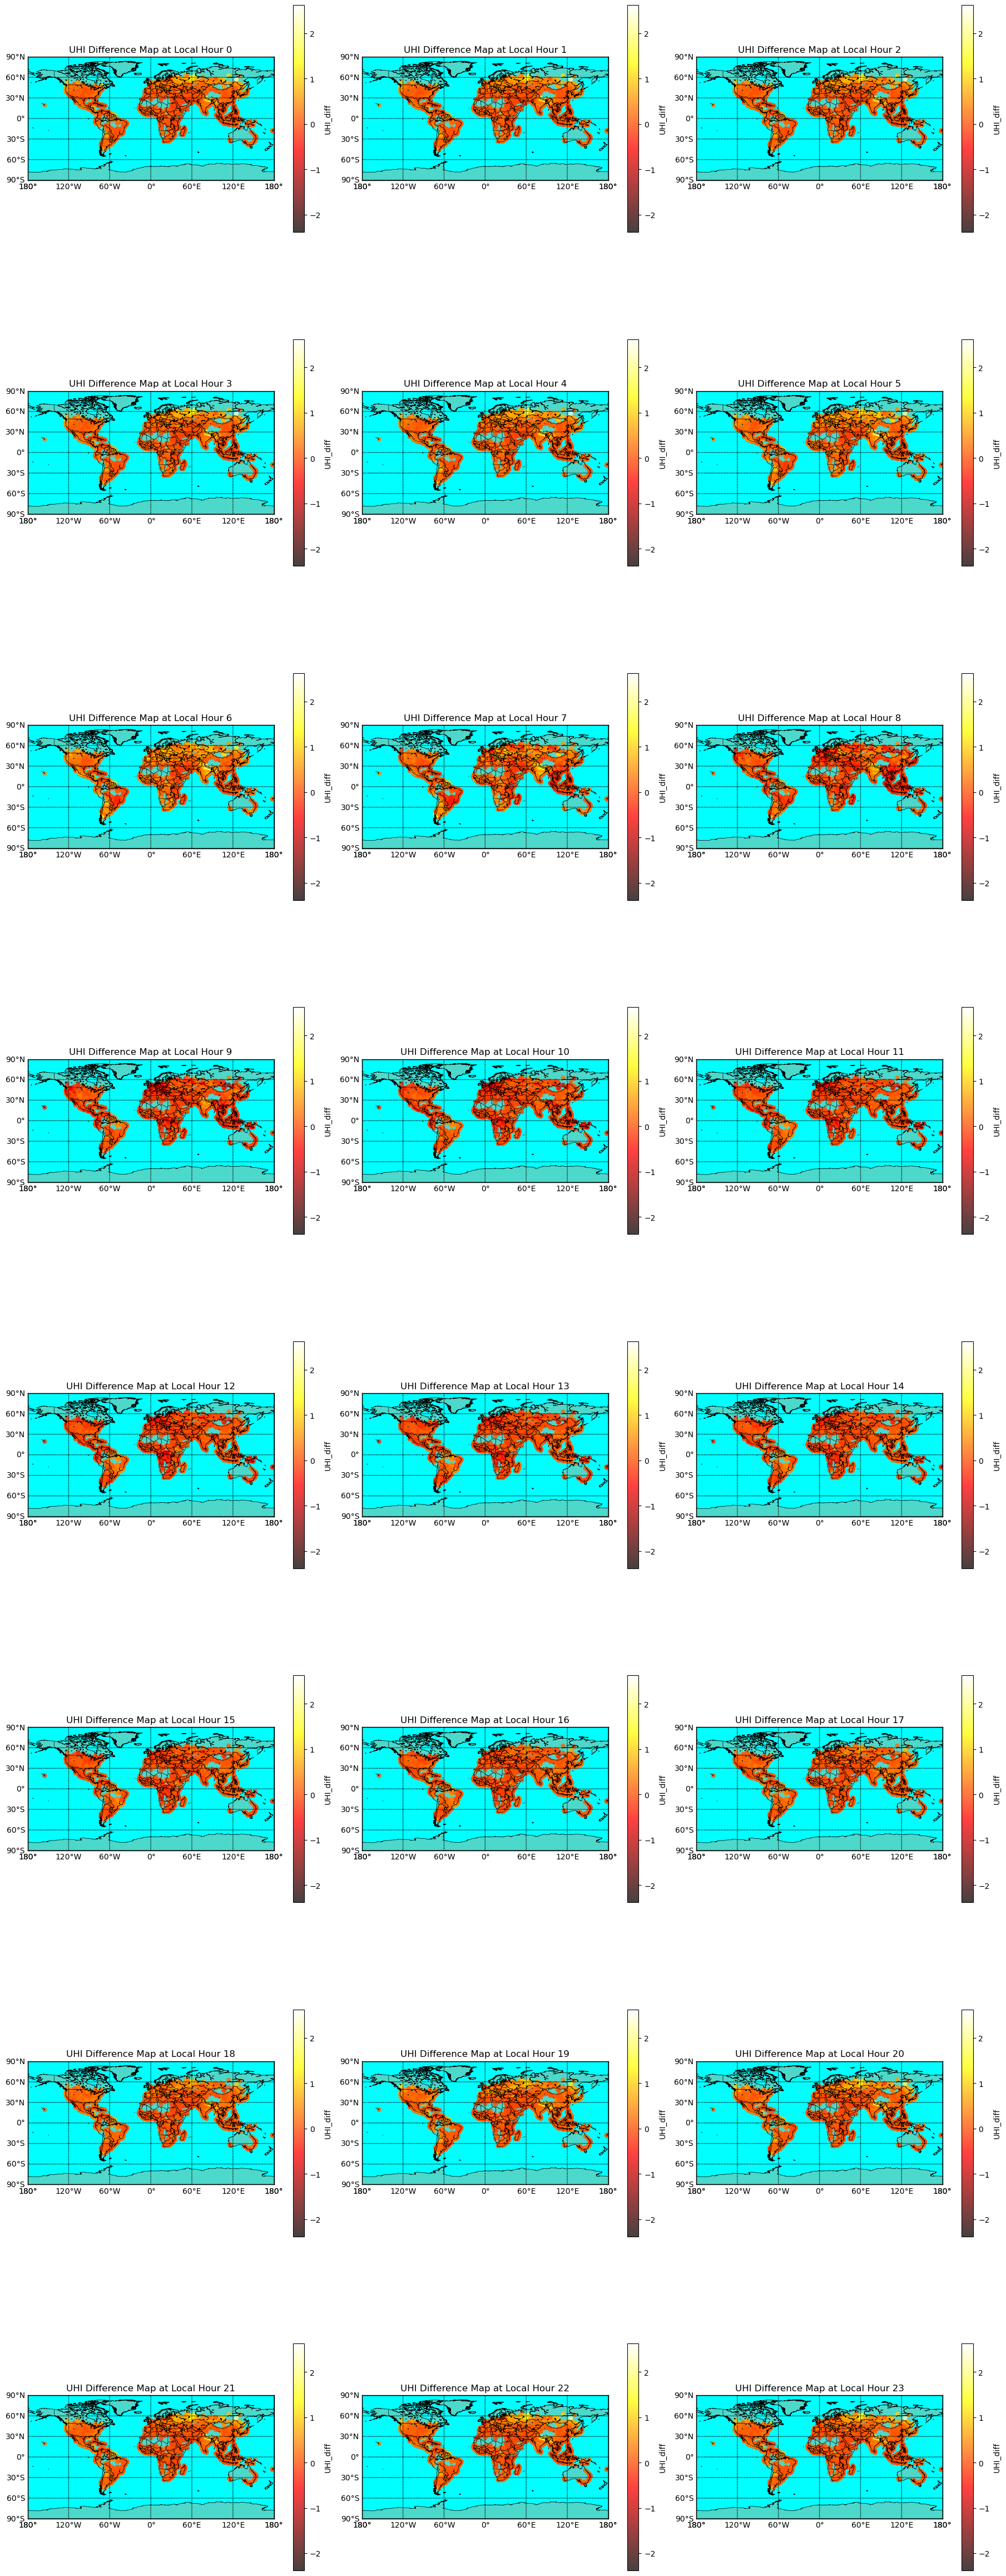

In [23]:



# Define the map drawing function for subplots
def draw_map_subplot(m, ax):
    m.drawcoastlines(linewidth=0.5, ax=ax)
    m.drawcountries(linewidth=0.5, ax=ax)
    m.fillcontinents(color='coral', lake_color='aqua', alpha=0.3, ax=ax)
    m.drawmapboundary(fill_color='aqua', ax=ax)
    m.drawparallels(np.arange(-90., 91., 30.), labels=[1, 0, 0, 0], fontsize=10, ax=ax)
    m.drawmeridians(np.arange(-180., 181., 60.), labels=[0, 0, 0, 1], fontsize=10, ax=ax)

# Find global min and max of UHI_diff
global_min = var_diff_by_localhour['UHI_diff'].min()
global_max = var_diff_by_localhour['UHI_diff'].max()

# Calculate the number of rows needed for the subplots
n_hours = len(var_diff_by_localhour['local_hour'].unique())
n_rows = (n_hours + 2) // 3  # Adding 2 to ensure rounding up if there's a remainder

# Create a figure to hold all subplots
fig, axs = plt.subplots(n_rows, 3, figsize=(18, n_rows * 6), constrained_layout=True)

# Iterate through each local_hour to create subplots
for i, hour in enumerate(var_diff_by_localhour['local_hour'].unique()):
    row, col = divmod(i, 3)
    ax = axs[row, col] if n_rows > 1 else axs[col]  # Adjust for the case of a single row

    # Setup the Basemap
    m = Basemap(projection='cyl', resolution='l', lat_0=0, lon_0=0, ax=ax)

    draw_map_subplot(m, ax)

    # Filter data for the current hour
    df_hour = var_diff_by_localhour[var_diff_by_localhour['local_hour'] == hour]

    # Scatter UHI_diff data
    x, y = m(df_hour['lon'].values, df_hour['lat'].values)
    # Set vmin and vmax to the global min/max values
    sc = m.scatter(x, y, c=df_hour['UHI_diff'], vmin=global_min, vmax=global_max, cmap='hot', marker='o', edgecolor='none', alpha=0.75, ax=ax)

    ax.set_title(f'UHI Difference Map at Local Hour {hour}')

    # Add color bar to each subplot
    plt.colorbar(sc, ax=ax, fraction=0.046, pad=0.04, label='UHI_diff')

plt.show()



## UHI_diff by local hour

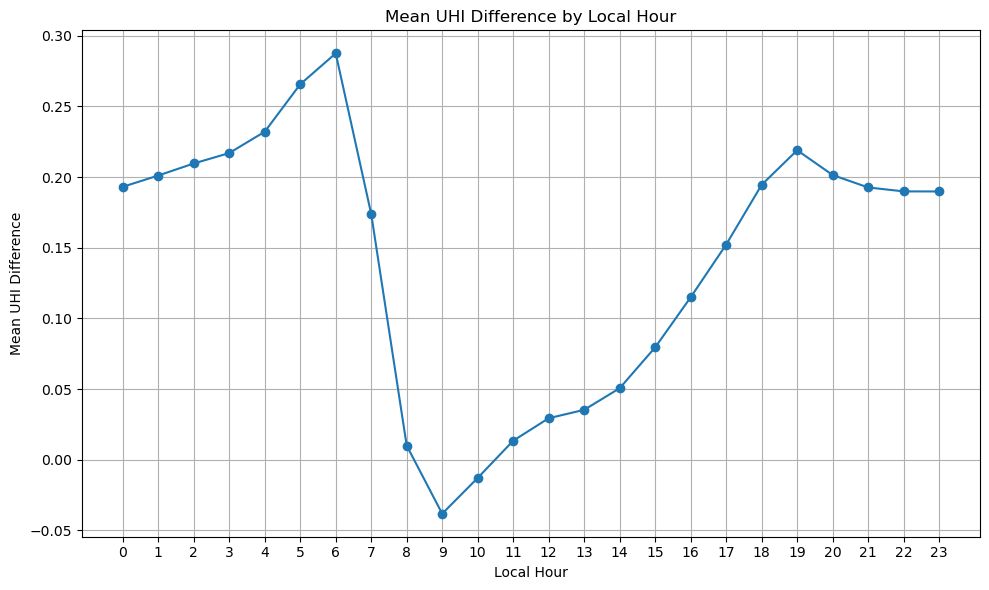

In [24]:
# Grouping by 'local_hour' and calculating the mean of 'UHI_diff'
uhi_hourly = var_diff_by_localhour.groupby('local_hour')['UHI_diff'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(uhi_hourly['local_hour'], uhi_hourly['UHI_diff'], marker='o')
plt.title('Mean UHI Difference by Local Hour')
plt.xlabel('Local Hour')
plt.ylabel('Mean UHI Difference')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

I have some understanding about UHI:
1. Diurnal Cycle of Solar Radiation: During the daytime, solar radiation is the primary source of heat for both urban and rural areas. However, urban surfaces, with their lower albedo and higher heat capacity, tend to absorb and store more solar radiation than rural surfaces. This leads to a smaller UHI effect during the day. At night, the absence of solar radiation allows the stored heat in urban areas to be gradually released, resulting in a stronger UHI effect at night.
2. Boundary Layer Dynamics: The atmospheric boundary layer, the layer of air closest to the Earth's surface, plays a crucial role in heat dissipation. During the day, the boundary layer is typically deeper and more turbulent, promoting greater mixing and heat exchange between the surface and the atmosphere. This can help to mitigate the UHI effect. At night, the boundary layer becomes shallower and more stable, trapping heat near the surface and intensifying the UHI effect.

I need to better understand why the synergy is also showing a diurnal cycle.

##  Koppen Geiger Climate Analysis

###  step 1: load the koppen geiger map and legend

In [25]:

import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the NetCDF file
ds_koppen_map = xr.open_dataset('/home/jguo/other_projects/1991_2020/koppen_geiger_0p5.nc')
#ds_koppen_map.kg_class.min()

# Load the Koppen Geiger Legend Excel file
kg_legend = pd.read_excel('/home/jguo/research/hw_global/Data/KoppenGeigerLegend.xlsx', engine='openpyxl')
kg_legend

,ID,KGShort,KGClass,Color
0,1,Af,"Tropical, rainforest",[0 0 255]
1,2,Am,"Tropical, monsoon",[0 120 255]
2,3,Aw,"Tropical, savannah",[70 170 250]
3,4,BWh,"Arid, desert, hot",[255 0 0]
4,5,BWk,"Arid, desert, cold",[255 150 150]
5,6,BSh,"Arid, steppe, hot",[245 165 0]
6,7,BSk,"Arid, steppe, cold",[255 220 100]
7,8,Csa,"Temperate, dry summer, hot summer",[255 255 0]
8,9,Csb,"Temperate, dry summer, warm summer",[200 200 0]
9,10,Csc,"Temperate, dry summer, cold summer",[150 150 0]


###  step 2: Find the nearest Koppen Geiger class for each grid cell

In [26]:

# Convert latitudes and longitudes from the NetCDF dataset to numpy arrays
latitudes = ds_koppen_map['lat'].values
longitudes = ds_koppen_map['lon'].values

# Flatten the latitudes, longitudes, and kg_class for easier manipulation
lat_flat = np.repeat(latitudes, len(longitudes))
lon_flat = np.tile(longitudes, len(latitudes))
kg_class_flat = ds_koppen_map['kg_class'].values.flatten()

# Filter out the zero kg_class values
non_zero_indices = kg_class_flat > 0
lat_flat_non_zero = lat_flat[non_zero_indices]
lon_flat_non_zero = lon_flat[non_zero_indices]
kg_class_flat_non_zero = kg_class_flat[non_zero_indices]

# Function to find the nearest non-zero kg_class for given lat and lon
def find_nearest_non_zero_kg_class(lat, lon):
    distances = np.sqrt((lat_flat_non_zero - lat)**2 + (lon_flat_non_zero - lon)**2)
    nearest_index = np.argmin(distances)
    return kg_class_flat_non_zero[nearest_index]

# Vectorize the function to apply it efficiently to arrays
vec_find_nearest_non_zero_kg_class = np.vectorize(find_nearest_non_zero_kg_class)

# Apply the vectorized function to each lat and lon in var_diff_by_localhour
var_diff_by_localhour['KG_ID'] = vec_find_nearest_non_zero_kg_class(var_diff_by_localhour['lat'].values, var_diff_by_localhour['lon'].values)
var_diff_by_localhour

,lat,lon,local_hour,UHI_diff,KG_ID
0,-45.706806,-67.50,0,0.276915,5.0
1,-45.706806,-67.50,1,0.247969,5.0
2,-45.706806,-67.50,2,0.234921,5.0
3,-45.706806,-67.50,3,0.213385,5.0
4,-45.706806,-67.50,4,0.280370,5.0
...,...,...,...,...,...
86755,63.612564,53.75,19,0.857440,27.0
86756,63.612564,53.75,20,0.979019,27.0
86757,63.612564,53.75,21,0.668540,27.0
86758,63.612564,53.75,22,0.493305,27.0


###  step 3: Plot the UHI_diff by local hour for each Koppen Geiger class

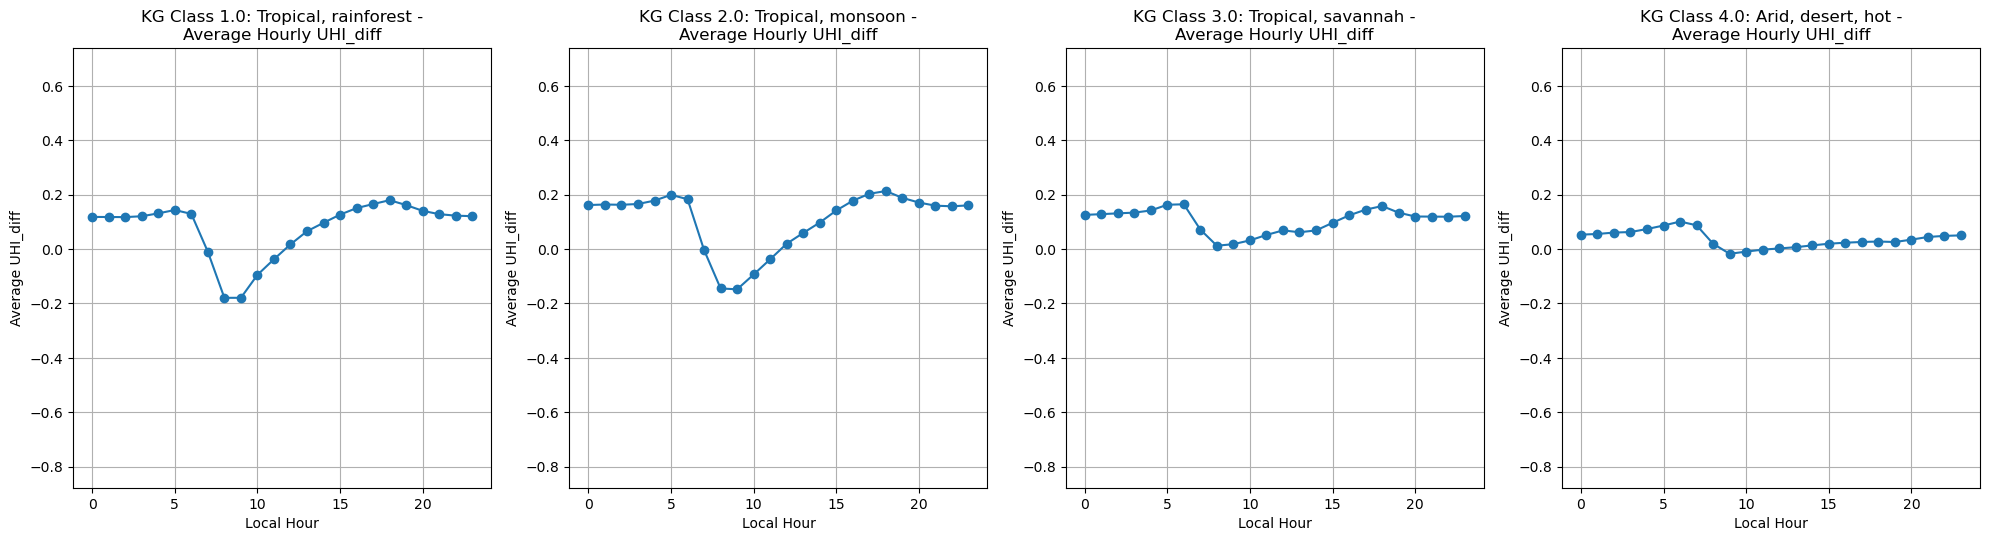

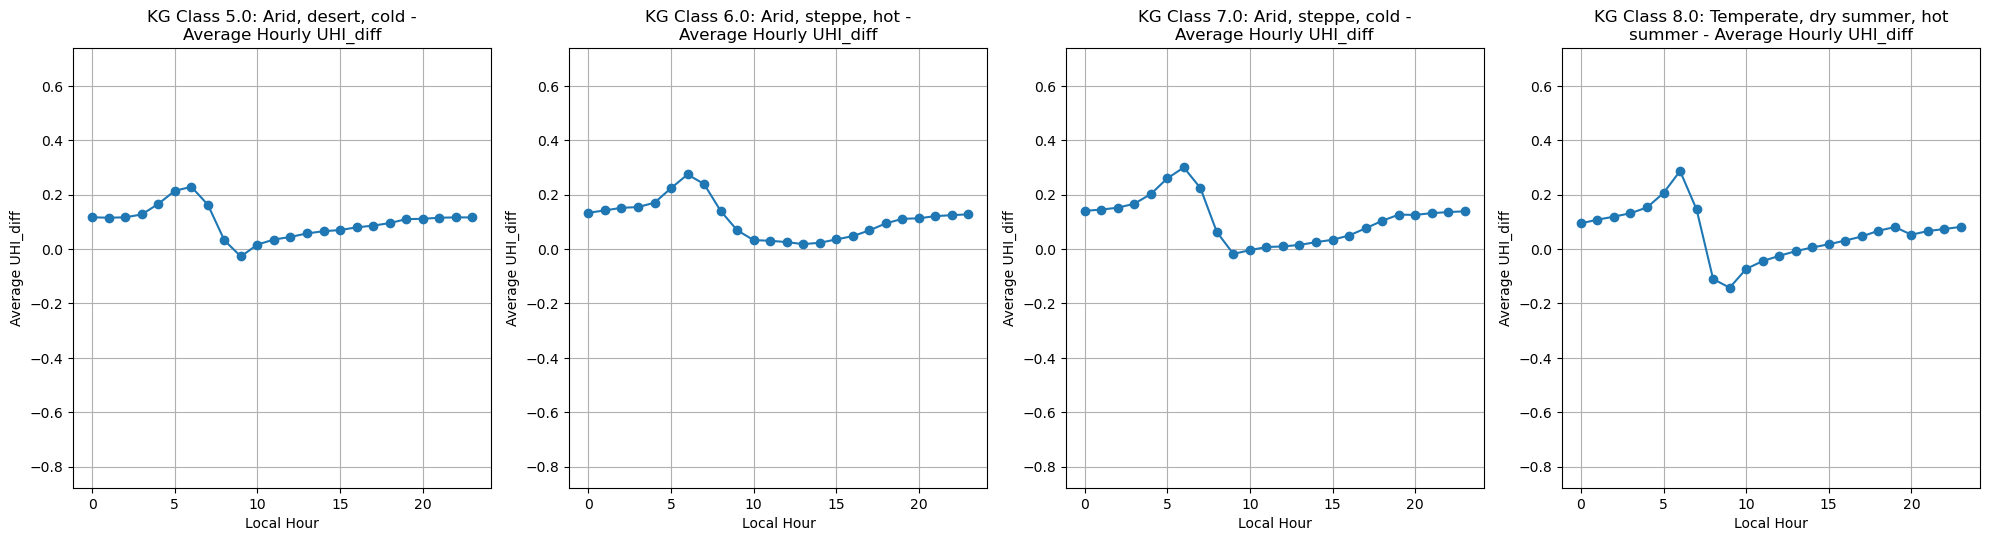

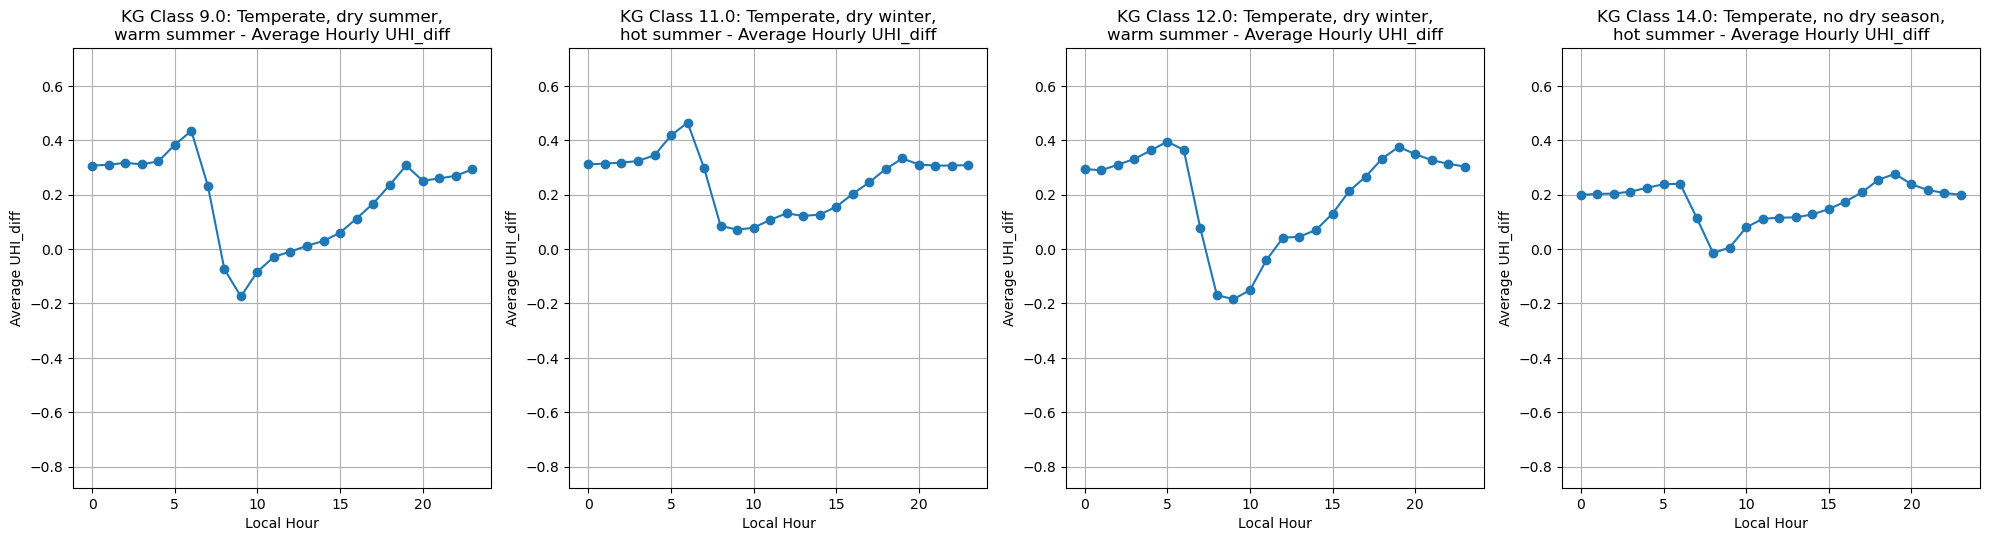

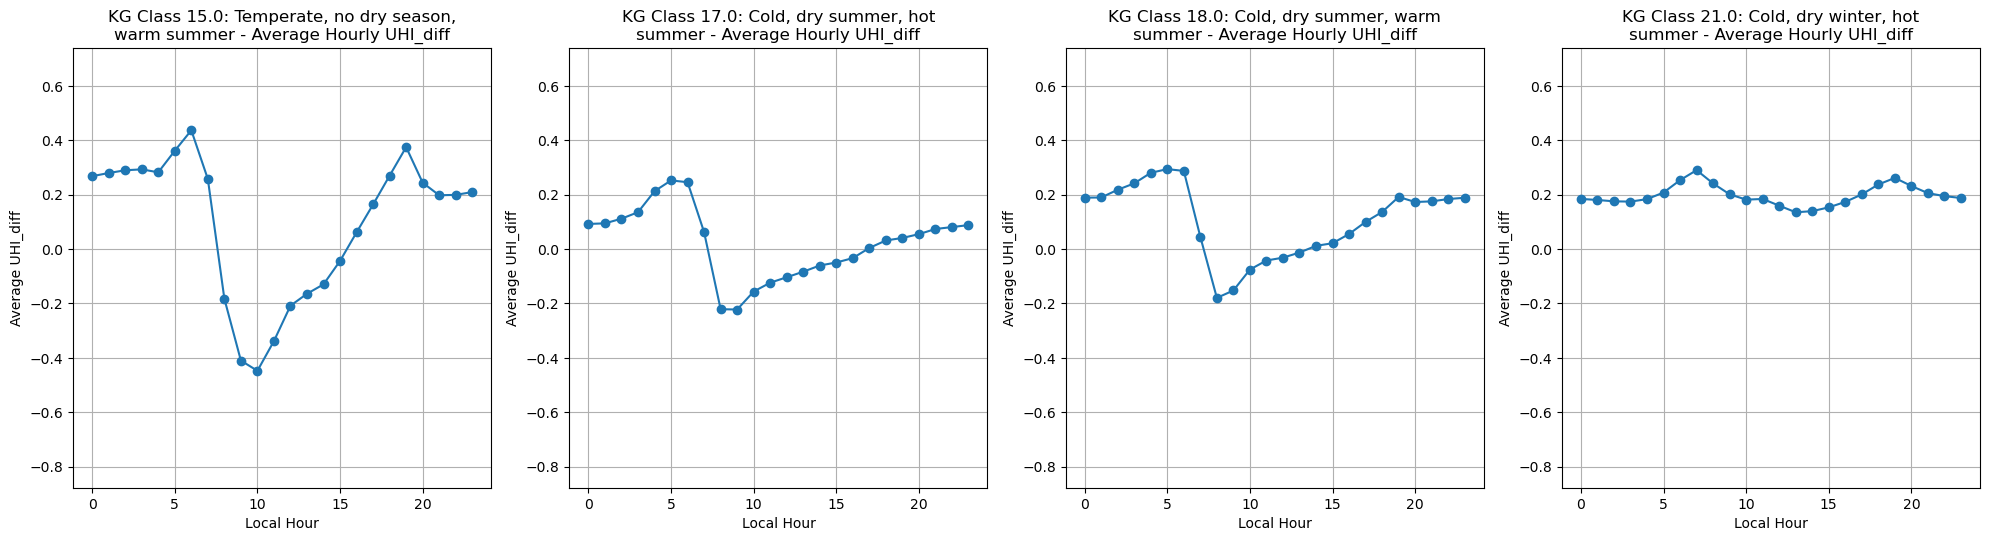

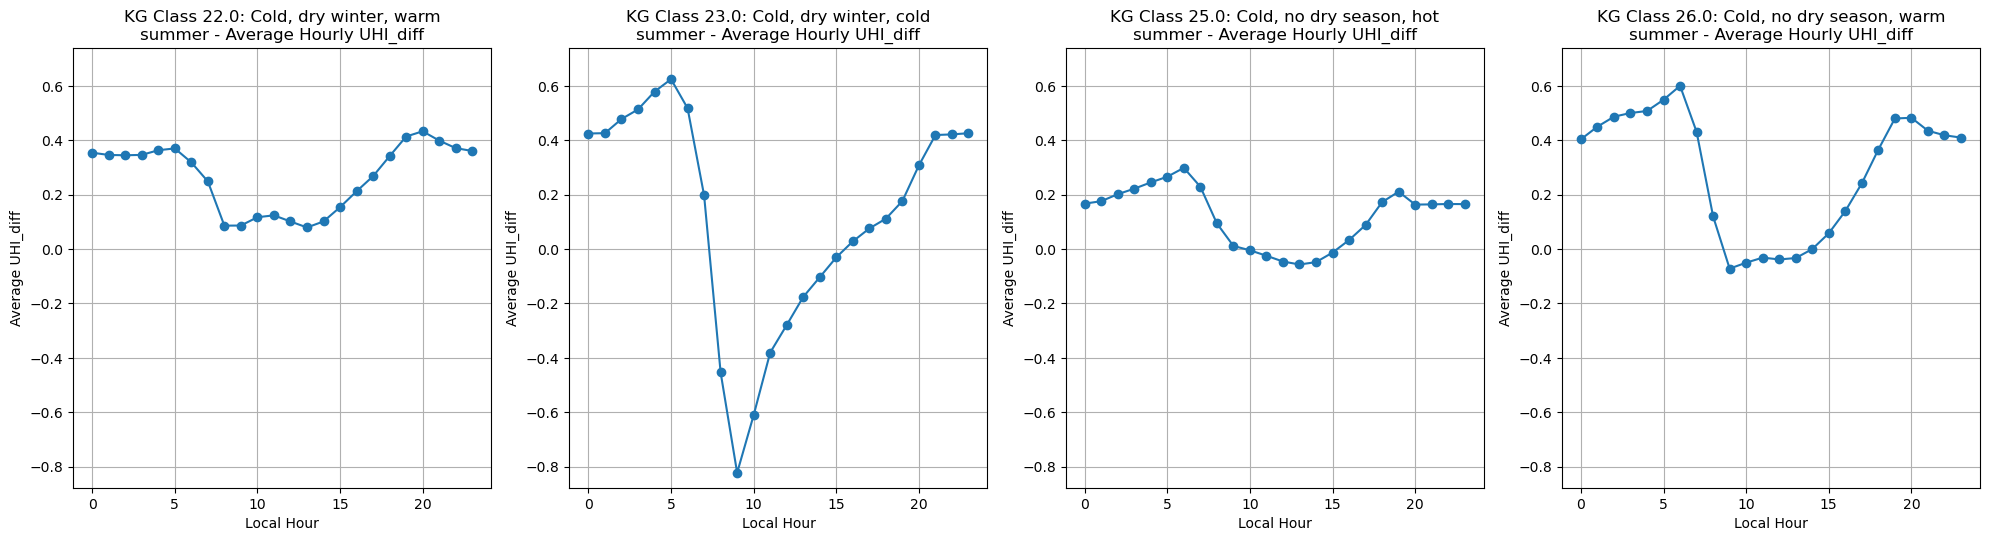

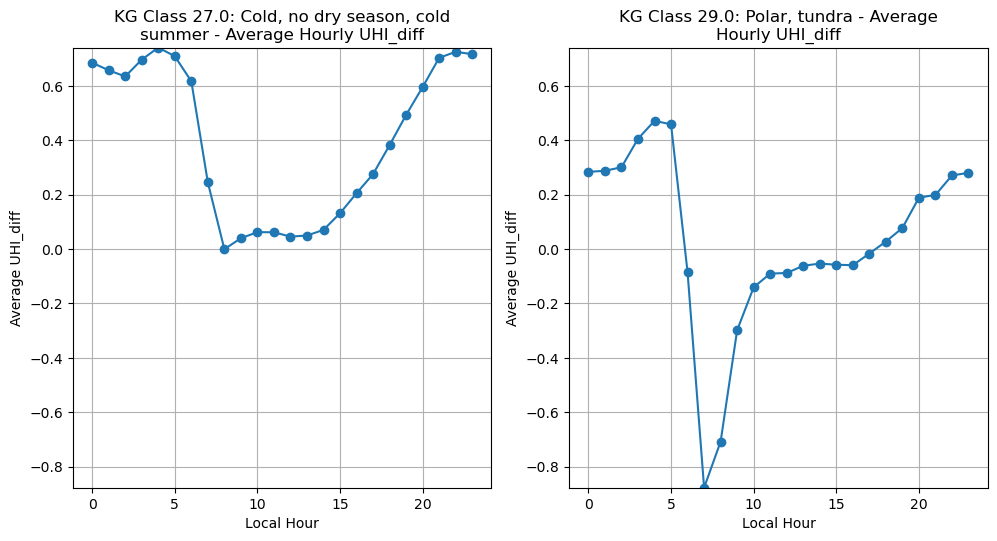

In [27]:

# Calculate average UHI_diff by local_hour for each KG class
avg_uhi_by_hour_and_kg = var_diff_by_localhour.groupby(['KG_ID', 'local_hour'])['UHI_diff'].mean().reset_index()
# Map KG classes to their descriptions
kg_map = dict(zip(kg_legend['ID'], kg_legend['KGClass']))
# Plotting
import textwrap

# Define the number of graphs you want in each row
graphs_per_row = 4  # You can change this number to your preference

# Find the global minimum and maximum UHI_diff values for consistent y-axis limits
global_min_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].min()
global_max_uhi = avg_uhi_by_hour_and_kg['UHI_diff'].max()

# Unique KG IDs
unique_kg_ids = avg_uhi_by_hour_and_kg['KG_ID'].unique()

# Number of KG IDs
n_kg_ids = len(unique_kg_ids)

# Calculate the number of rows needed
n_rows = (n_kg_ids + graphs_per_row - 1) // graphs_per_row  # Ensures rounding up

# Loop through each KG ID
for i, kg_id in enumerate(unique_kg_ids):
    # Create a new figure at the start and after every 'graphs_per_row' plots
    if i % graphs_per_row == 0:
        plt.figure(figsize=(5 * graphs_per_row, 5 * n_rows))  # Adjust figure size as needed
    # Select the subplot position
    plt.subplot(n_rows, graphs_per_row, i % graphs_per_row + 1)

    # Extract the subset of data for the current KG ID
    subset = avg_uhi_by_hour_and_kg[avg_uhi_by_hour_and_kg['KG_ID'] == kg_id]

    # Plot the data
    plt.plot(subset['local_hour'], subset['UHI_diff'], marker='o')

    # Wrap the title text
    title_text = f'KG Class {kg_id}: {kg_map.get(kg_id, "Unknown")} - Average Hourly UHI_diff'
    wrapped_title = textwrap.fill(title_text, width=40)  # Adjust 'width' as needed

    plt.title(wrapped_title)
    plt.xlabel('Local Hour')
    plt.ylabel('Average UHI_diff')
    plt.grid(True)

    # Set the same y-axis limits for all plots
    plt.ylim(global_min_uhi, global_max_uhi)

    # Show the figure after every 'graphs_per_row' plots or on the last plot
    if (i % graphs_per_row == graphs_per_row - 1) or (i == n_kg_ids - 1):
        plt.tight_layout()
        plt.show()






# 5. Next Steps: Statistical Analysis and Interpretation

## 5.1: Statistical Analysis: LHS UHI_diff or UBWI_diff. RHS KG_ID (major and sub categories), day and night (we are going to collapse the hours into day and night)

## 5.2: Try using UHI_hour on the LHS and perform similar analysis as above.  

## 5.3: Coastline analysis. (optional because Kopphen Geiger zones has in a way already capture the coastal effect to me) 

#   Miscalanous items

## Count number of HW days

In [ ]:
df_count = df_hw.groupby(['lat', 'lon']).size()
df_count

In [ ]:
df_count_sorted = df_count.sort_values(ascending=False).reset_index()
df_count_sorted

In [ ]:

df_count_sorted['lon'] = df_count_sorted['lon'].apply(normalize_longitude)
df_count_sorted = df_count_sorted.set_index(['lat', 'lon']) 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
# Create a figure with a specific size
plt.figure(figsize=(12, 6))
df_count_sorted /= 365 # number of HW days per year

# Create a Basemap instance for a simple cylindrical projection, with coastlines and country boundaries
m = Basemap(projection='cyl', resolution='c', llcrnrlat=-90, urcrnrlat=90, llcrnrlon=-180, urcrnrlon=180)
m.drawcoastlines(linewidth=0.5)
m.drawcountries(linewidth=0.5)

# Convert latitudes and longitudes to map projection coordinates
x, y = m(df_count_sorted.index.get_level_values('lon').values, df_count_sorted.index.get_level_values('lat').values)

# Scatter plot: plotting the total HW values for each grid cell on the map
m.scatter(x, y, c=df_count_sorted.values, s=10, cmap='Reds', alpha=0.75, latlon=False)

# Add a color bar to indicate the scale of HW values
plt.colorbar(label='Total HW / Year')

# Title for the map
plt.title('Global Map Showing Total HW on Each Grid Cell')

plt.show()

## group by north south hemisphere

In [ ]:
var_diff_by_localhour.groupby(lambda x: (var_diff_by_localhour.loc[x, 'lat'] > 0, var_diff_by_localhour.loc[x, 'local_hour']))['UHI_diff'].mean()

## Load koppen map tiff file

In [ ]:
import xarray as xr
import rioxarray

# Open the GeoTIFF file as an xarray DataSet
#file_path = '/home/jguo/other_projects/koppen_geiger_tif/1991_2020/koppen_geiger_0p1.tif'
pic_path = '/home/jguo/other_projects/koppen_geiger_tif/1991_2020/koppen_geiger_1p0.tif'
# xds = rioxarray.open_rasterio('/home/jguo/other_projects/koppen_geiger_tif/1991_2020/koppen_geiger_0p1.tif')
ds_koppen = xr.open_dataset(pic_path, engine="rasterio")
# Now `xds` is an xarray DataSet with the raster data and spatial coordinates
ds_koppen




In [ ]:
import rasterio
src = rasterio.open(pic_path)
src.colormap(1)

In [ ]:
ds_koppen.band_data.plot()

In [ ]:
ds_koppen.to_dataframe()